Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Rescaling
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("train")
data_dir_test = pathlib.Path("test")

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader.

In [4]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [5]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [6]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height,img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [7]:
#Lets confirm the number of batches in the train_ds (1792/32=56 batches) for trainin and 447/32=14 batches for validation
print("train Batches:", len(train_ds))
print("test Batches:", len(val_ds))

train Batches: 56
test Batches: 14


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
train_classes = train_ds.class_names
print(len(train_classes),'Classes:', train_classes)

9 Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
# Lets's ensure same classes are all covered in both train and validation data sets
print("Train Classes:",len(train_ds.class_names),'Classes:', train_ds.class_names)
print("Validation Classes:",len(val_ds.class_names),'Classes:', val_ds.class_names)

Train Classes: 9 Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
Validation Classes: 9 Classes: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [10]:
#We confirmed that both data sets have same classes; from this point we will use the classes_names and class_num
class_names=train_ds.class_names
num_classes=len(class_names)

### Visualize the data
#### Let's visualize one batch of 32 images from the train_ds; Note that some batches might not include images of all 9 classes.

In [11]:
plt.figure(figsize=(20,100))
for images,labels in train_ds.take(1):
    for i in range(32):
        ax=plt.subplot(24,4,i+1)
        plt.imshow(images[i].numpy().astype("int"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

 #### Let's visualize one image of each class; as a single batch might not include images of all classes, we will create a single batch of all images and run our to find one image of each class.

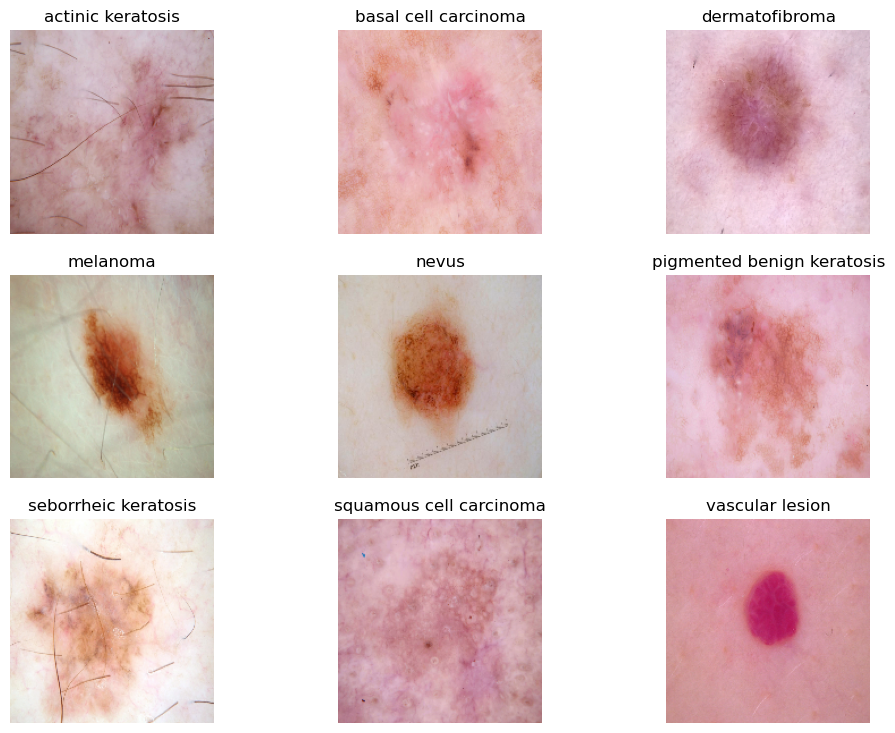

In [13]:
all_elements = train_ds.unbatch()
single_batch = all_elements.repeat().batch(1792)     #Full train dataset (1792 images)
plt.figure(figsize=(12,len(train_classes)))
i=0
c= class_names[i]
for images,labels in single_batch:
    i=i+1
    for j in range(1792):
        if c == class_names[labels[j]]:
            ax=plt.subplot(3,3,i)
            plt.imshow(images[j].numpy().astype("int"))
            plt.title(class_names[labels[j]])
            plt.axis("off")
            break
    if i==len(class_names):
        break
    else:
        c= class_names[i]

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 18s 172ms/step - loss: 1.8002 - accuracy: 0.3560 - val_loss: 1.7212 - val_accuracy: 0.3736
Epoch 2/20
56/56 [==============================] - 7s 128ms/step - loss: 1.5213 - accuracy: 0.4598 - val_loss: 1.4455 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 7s 127ms/step - loss: 1.3937 - accuracy: 0.5123 - val_loss: 1.4044 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 7s 128ms/step - loss: 1.3235 - accuracy: 0.5335 - val_loss: 1.4338 - val_accuracy: 0.5235
Epoch 5/20
56/56 [==============================] - 7s 127ms/step - loss: 1.2451 - accuracy: 0.5552 - val_loss: 1.4042 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 7s 128ms/step - loss: 1.1368 - accuracy: 0.5938 - val_loss: 1.4613 - val_accuracy: 0.5078
Epoch 7/20
56/56 [==============================] - 7s 127ms/step - loss: 1.0857 - accuracy: 0.6166 - val_loss: 1.4186 - val_accuracy: 0.5324
Epoch

### Visualizing training results

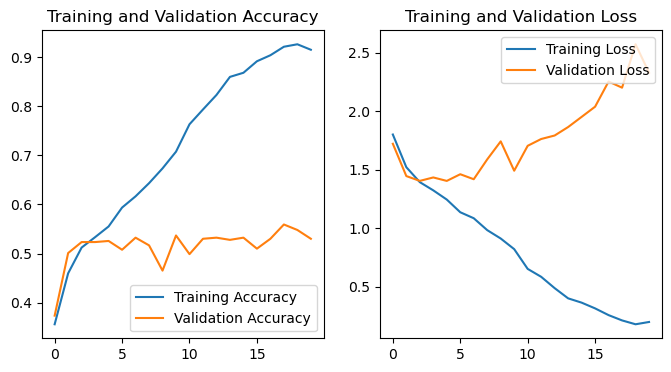

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The above analysis of the model training/validation Accurecy and Loss provides evidence of model overfitting. The training increased with epochs to exceed 90% and the loss decreased to less than 0.5, while the validation accuracy was alternating around 50% and the loss decreased at the begining and then starts increasing. This proves that the model is overfitting. The overfitting is due to the small number of images so the model is unable to detect the patterns and remembered the training images.
#### To solve the overfitting problem, we need to generate more images using augmentation.

### To solve the overfitting problem, we need to generate more images using some augmentation strategies.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

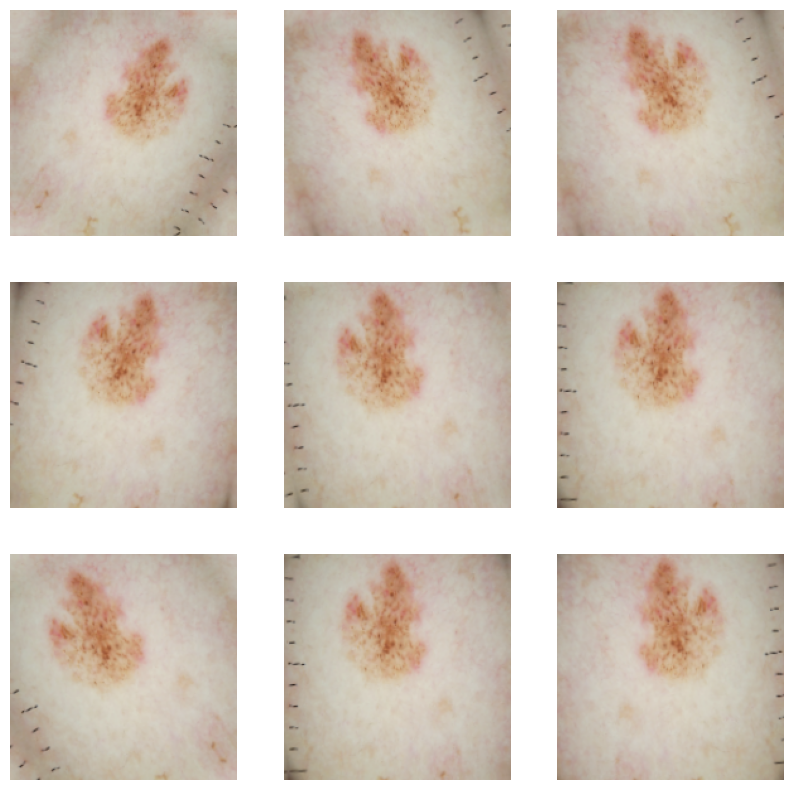

In [54]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Create a new model with Augmentation

In [55]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [25]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 10s 155ms/step - loss: 2.0630 - accuracy: 0.2210 - val_loss: 1.9210 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 8s 148ms/step - loss: 1.8731 - accuracy: 0.3108 - val_loss: 1.8732 - val_accuracy: 0.3244
Epoch 3/20
56/56 [==============================] - 8s 148ms/step - loss: 1.6946 - accuracy: 0.3979 - val_loss: 1.6240 - val_accuracy: 0.4586
Epoch 4/20
56/56 [==============================] - 8s 148ms/step - loss: 1.6649 - accuracy: 0.4018 - val_loss: 1.6448 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 8s 148ms/step - loss: 1.5739 - accuracy: 0.4453 - val_loss: 1.5148 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 8s 148ms/step - loss: 1.4401 - accuracy: 0.4972 - val_loss: 1.4199 - val_accuracy: 0.5034
Epoch 7/20
56/56 [==============================] - 8s 148ms/step - loss: 1.4187 - accuracy: 0.5050 - val_loss: 1.4658 - val_accuracy: 0.4810
Epoch

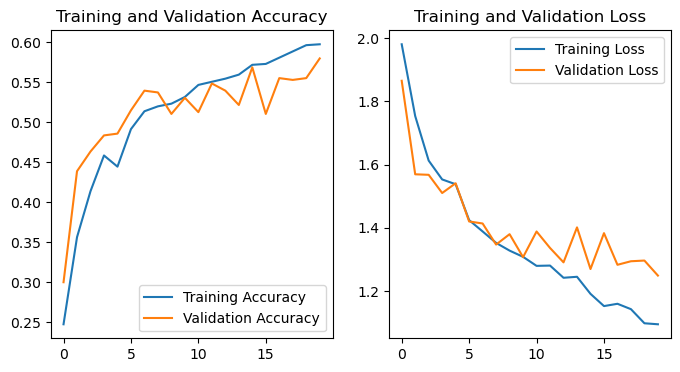

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Augmentation minimizes the difference between training and validation accuracy, but didn't increase the validation accuracy as expected. As the first model without Augmentation was overfitting let's try adding Dropout layer

In [36]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 137ms/step - loss: 2.0695 - accuracy: 0.2171 - val_loss: 1.8769 - val_accuracy: 0.3356
Epoch 2/20
56/56 [==============================] - 7s 129ms/step - loss: 1.7438 - accuracy: 0.3895 - val_loss: 1.5218 - val_accuracy: 0.4922
Epoch 3/20
56/56 [==============================] - 7s 129ms/step - loss: 1.5001 - accuracy: 0.4967 - val_loss: 1.4702 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 7s 129ms/step - loss: 1.3380 - accuracy: 0.5435 - val_loss: 1.4474 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 7s 129ms/step - loss: 1.2945 - accuracy: 0.5519 - val_loss: 1.3087 - val_accuracy: 0.5503
Epoch 6/20
56/56 [==============================] - 7s 129ms/step - loss: 1.2332 - accuracy: 0.5608 - val_loss: 1.4111 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 7s 129ms/step - loss: 1.1454 - accuracy: 0.5887 - val_loss: 1.4753 - val_accuracy: 0.5503
Epoch 

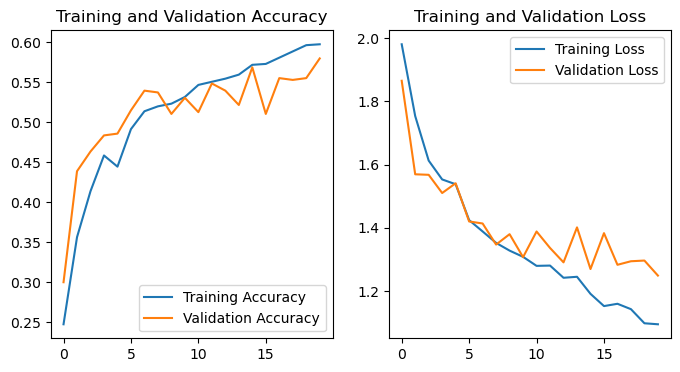

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We see that dropout  doesn't increas the accuracy of the model much. We will use the model with Augmentation as the train and validation accuracy are much close. Tried more epochs (30) it increased the training accuracy, but not the validation. 
#### Let's try to add additional hiddent layer to the model

In [51]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [52]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 12s 186ms/step - loss: 1.9805 - accuracy: 0.2472 - val_loss: 1.8651 - val_accuracy: 0.2998
Epoch 2/20
56/56 [==============================] - 9s 156ms/step - loss: 1.7535 - accuracy: 0.3560 - val_loss: 1.5693 - val_accuracy: 0.4385
Epoch 3/20
56/56 [==============================] - 9s 156ms/step - loss: 1.6126 - accuracy: 0.4135 - val_loss: 1.5677 - val_accuracy: 0.4631
Epoch 4/20
56/56 [==============================] - 9s 156ms/step - loss: 1.5530 - accuracy: 0.4581 - val_loss: 1.5101 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 9s 156ms/step - loss: 1.5379 - accuracy: 0.4442 - val_loss: 1.5410 - val_accuracy: 0.4855
Epoch 6/20
56/56 [==============================] - 9s 156ms/step - loss: 1.4243 - accuracy: 0.4911 - val_loss: 1.4201 - val_accuracy: 0.5145
Epoch 7/20
56/56 [==============================] - 9s 156ms/step - loss: 1.3886 - accuracy: 0.5134 - val_loss: 1.4137 - val_accuracy: 0.5391
Epoch

#### Better results accuracy of around 60% for train and 58% for validation; little improvement but still very low accuracy

#### Find the distribution of classes in the train dataset
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [104]:
import glob
n = len(list(data_dir_train.glob('*/*.jpg')))
print('Total train images:', n)
for i in class_names:
    class_dir=pathlib.Path('train'+'/'+i)
    k=len(list(class_dir.glob('*.jpg')))
    print(str(k) +' images  '+str(round(k/n*100))+'%', i)

Total train images: 2239
114 images  5% actinic keratosis
376 images  17% basal cell carcinoma
95 images  4% dermatofibroma
438 images  20% melanoma
357 images  16% nevus
462 images  21% pigmented benign keratosis
77 images  3% seborrheic keratosis
181 images  8% squamous cell carcinoma
139 images  6% vascular lesion


#### We notice here that different classes have different number of samples 
#### <i><u>'seborrheic keratosis'</i></u> has the least number of samples 77(3%), while <i><u>'pigmented benign keratosis'</i></u> has the biggest number 462 (21%)
#### <i><u>'pigmented benign keratosis'</i></u> and <i><u>'melanoma'</i></u> dominate the dataset 

### Rectifying the class imbalance
#### Use `Augmentor` to add more samples across all classes so that none of the classes have very few samples.

In [59]:
!pip install Augmentor

     ---------------------------------------- 0.0/77.1 kB ? eta -:--:--
     -------------------- ----------------- 41.0/77.1 kB 960.0 kB/s eta 0:00:01
     -------------------------------------- 77.1/77.1 kB 846.3 kB/s eta 0:00:00


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [71]:
path_to_training_dataset=data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(str(path_to_training_dataset) +'/'+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25E6CC28790>: 100%|██████████| 500/500 [00:04<00:00, 100.65 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25EA4556EB0>: 100%|██████████| 500/500 [00:05<00:00, 87.88 Samples/s]                   


Initialised with 95 image(s) found.
Output directory set to train/dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x25DABBC49A0>: 100%|██████████| 500/500 [00:06<00:00, 82.36 Samples/s] 


Initialised with 438 image(s) found.
Output directory set to train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x25DABB94130>: 100%|██████████| 500/500 [00:29<00:00, 16.95 Samples/s] 


Initialised with 357 image(s) found.
Output directory set to train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=824x719 at 0x25DABBAC400>: 100%|██████████| 500/500 [00:26<00:00, 18.58 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25E6CF652B0>: 100%|██████████| 500/500 [00:06<00:00, 72.45 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to train/seborrheic keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x25E6AA5BF70>: 100%|██████████| 500/500 [00:16<00:00, 31.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25EA4563700>: 100%|██████████| 500/500 [00:07<00:00, 66.10 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x25E78B27D30>: 100%|██████████| 500/500 [00:07<00:00, 71.03 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [105]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Added 500 images to each class; total 4500 for 9 classes
#### Lets see the distribution of augmented data after adding new images to the original training data.

In [111]:
o = len(list(data_dir_train.glob('*/*.jpg')))
a = len(list(data_dir_train.glob('*/output/*.jpg')))
print('Total train images:',o+a, str(o)+' Originals ; '+str(a)+' Augmented')
for i in class_names:
    class_dir=pathlib.Path('train'+'/'+i)
    k=len(list(class_dir.glob('*.jpg')))
    l=len(list(class_dir.glob('output/*.jpg')))
    print(str(k+l) +' images  '+str(round((k+l)/n*100))+'%', i)

Total train images: 6739 2239 Originals ; 4500 Augmented
614 images  9% actinic keratosis
876 images  13% basal cell carcinoma
595 images  9% dermatofibroma
938 images  14% melanoma
857 images  13% nevus
962 images  14% pigmented benign keratosis
577 images  9% seborrheic keratosis
681 images  10% squamous cell carcinoma
639 images  9% vascular lesion


#### We see now that the nine classes are much more balanced with distribution between 9% and 14% for each class

In [138]:
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','.','*.jpg'))]

In [139]:
lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train,'*','.', '*.jpg'))]

In [140]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [141]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [142]:
dataframe_dict=dict(zip(path_list, lesion_list))

In [143]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [148]:
org_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [149]:
aug_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [161]:
org_df.head()

Path              Label
0  train\actinic keratosis\.\ISIC_0025780.jpg  actinic keratosis
1  train\actinic keratosis\.\ISIC_0025803.jpg  actinic keratosis
2  train\actinic keratosis\.\ISIC_0025825.jpg  actinic keratosis
3  train\actinic keratosis\.\ISIC_0025953.jpg  actinic keratosis
4  train\actinic keratosis\.\ISIC_0025957.jpg  actinic keratosis

In [162]:
aug_df.head()

Path              Label
0  train\actinic keratosis\output\actinic keratos...  actinic keratosis
1  train\actinic keratosis\output\actinic keratos...  actinic keratosis
2  train\actinic keratosis\output\actinic keratos...  actinic keratosis
3  train\actinic keratosis\output\actinic keratos...  actinic keratosis
4  train\actinic keratosis\output\actinic keratos...  actinic keratosis

In [163]:
frames=[org_df, aug_df]
new_df=pd.concat(frames)

In [164]:
print(new_df['Label'].value_counts())

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64


#### So, now we have added 500 images to each classes to maintain some class balance. 
#### We will rebuild and train our model now on the new training dataset (original + augmented)

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [169]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [170]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [171]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [172]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [173]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 32s 186ms/step - loss: 1.9567 - accuracy: 0.2550 - val_loss: 1.5144 - val_accuracy: 0.4172
Epoch 2/30
169/169 [==============================] - 27s 154ms/step - loss: 1.4773 - accuracy: 0.4345 - val_loss: 1.3257 - val_accuracy: 0.5033
Epoch 3/30
169/169 [==============================] - 27s 154ms/step - loss: 1.2756 - accuracy: 0.5256 - val_loss: 1.3181 - val_accuracy: 0.5085
Epoch 4/30
169/169 [==============================] - 27s 156ms/step - loss: 1.1096 - accuracy: 0.5937 - val_loss: 1.1163 - val_accuracy: 0.5865
Epoch 5/30
169/169 [==============================] - 27s 155ms/step - loss: 0.9540 - accuracy: 0.6536 - val_loss: 1.1906 - val_accuracy: 0.5568
Epoch 6/30
169/169 [==============================] - 27s 154ms/step - loss: 0.8157 - accuracy: 0.7034 - val_loss: 0.9591 - val_accuracy: 0.6763
Epoch 7/30
169/169 [==============================] - 27s 153ms/step - loss: 0.6949 - accuracy: 0.7441 - val_loss: 0.8714 - val_ac

#### **Todo:**  Visualize the model results

In [175]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### We notice from the above results that rebalancing the classes has helped a lot in solving the underfitting problem. The accuracy is much better than training the model with only the original data.
#### Adding more augmented images might enhance the accuracy even more. Using more advanced augmentation strategies and adding more layers to the model, might also increase the accuracy more. I will try more enancements later that couldn;t complete because of time constraints. 
